In [4]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURATION ---
RAW_DATA_PATH = "../data/raw/online_retail_II.xlsx"
PROCESSED_DATA_PATH = "../data/processed/online_retail_cleaned.csv"

# 1. LOAD DATA 
print("Loading raw data...")
df_2009 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2009-2010')
df_2010 = pd.read_excel(RAW_DATA_PATH, sheet_name='Year 2010-2011')

# Combine both sheets
df = pd.concat([df_2009, df_2010], ignore_index=True)
print(f"Initial Row Count: {df.shape[0]:,}")

# 2. CLEANING: Remove Null CustomerIDs
# We cannot segment customers if we don't know who they are.
df = df.dropna(subset=['Customer ID'])
print(f"Rows after dropping null Customer ID: {df.shape[0]:,}")

# 3. CLEANING: Remove Cancellations & Bad Data
# Remove invoices starting with 'C' (Cancellations)
df = df[~df['Invoice'].astype(str).str.startswith('C')]

# Remove records with negative or zero Quantity/Price
df = df[(df['Quantity'] > 0) & (df['Price'] > 0)]

# 4. CLEANING: Filter Operational 'Junk' Codes
junk_codes = ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK', 'BANK CHARGES']
df = df[~df['StockCode'].isin(junk_codes)]

# 5. FEATURE ENGINEERING: Total Sales
df['TotalSales'] = df['Quantity'] * df['Price']

# 6. SAVE TO PROCESSED
#save as CSV to load faster next time.
print("Saving cleaned data...")
df.to_csv(PROCESSED_DATA_PATH, index=False)
print(f"SUCCESS! Final Cleaned Data Saved to: {PROCESSED_DATA_PATH}")
print(f"Final Row Count: {df.shape[0]:,}")

Loading raw data...
Initial Row Count: 1,067,371
Rows after dropping null Customer ID: 824,364
Saving cleaned data...
SUCCESS! Final Cleaned Data Saved to: ../data/processed/online_retail_cleaned.csv
Final Row Count: 802,932


In [5]:
#EXECUTING THE TRANSFORMATION


# CONFIGURATION 
# setting the 'Snapshot Date' to 1 day after the last transaction in the dataset
# This simulates doing the analysis on the day the data was pulled.
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

print(f"Snapshot Date: {snapshot_date}")

# AGGREGATION 
# Group by CustomerID and calculate RFM metrics
rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'Invoice': 'nunique',                                     # Frequency
    'TotalSales': 'sum'                                       # Monetary
})

# Rename columns for clarity
rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'TotalSales': 'Monetary'
}, inplace=True)

# Sanity Check
print(f"Customer Count: {rfm.shape[0]}")
display(rfm.head())

Snapshot Date: 2011-12-10 12:50:00
Customer Count: 5862


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,1658.40
12349.0,19,3,3678.69
12350.0,310,1,294.40


In [ ]:
# ============================================
# ADVANCED FEATURE ENGINEERING 
# ============================================
print("Starting Advanced Feature Engineering...")

# CRITICAL: Split data FIRST before building features
# Features must ONLY use data before cutoff date
cutoff_date = df['InvoiceDate'].max() - pd.DateOffset(days=90)
train_df = df[df['InvoiceDate'] < cutoff_date]
test_period_df = df[df['InvoiceDate'] >= cutoff_date]

print(f" Cutoff Date: {cutoff_date}")
print(f"   Training period rows: {len(train_df)}")
print(f"   Test period rows:     {len(test_period_df)}")

# Snapshot date is NOW the cutoff (not df max!)
snapshot_date = cutoff_date

# Step 1: Add time-based columns to TRAINING DATA ONLY
print("\n1/4: Calculating temporal patterns...")
train_df = train_df.copy()
train_df['hour']        = train_df['InvoiceDate'].dt.hour
train_df['day_of_week'] = train_df['InvoiceDate'].dt.dayofweek
train_df['is_weekend']  = (train_df['day_of_week'] >= 5).astype(int)

# Step 2: Calculate features PER CUSTOMER using TRAINING DATA ONLY
print("2/4: Engineering behavioral features...")
customer_features_list = []

for customer_id in train_df['Customer ID'].unique():
    customer_data = train_df[train_df['Customer ID'] == customer_id].copy()
    customer_data = customer_data.sort_values('InvoiceDate')

    features = {
        'Customer ID': customer_id,

        # RFM
        'Recency':   (snapshot_date - customer_data['InvoiceDate'].max()).days,
        'Frequency': customer_data['Invoice'].nunique(),
        'Monetary':  customer_data['TotalSales'].sum(),

        # Time-based
        'customer_age_days':       (customer_data['InvoiceDate'].max() - customer_data['InvoiceDate'].min()).days,
        'days_between_purchases':  (customer_data['InvoiceDate'].max() - customer_data['InvoiceDate'].min()).days / customer_data['Invoice'].nunique() if customer_data['Invoice'].nunique() > 1 else 0,

        # Recent activity
        'orders_last_30d': customer_data[customer_data['InvoiceDate'] > (snapshot_date - pd.Timedelta(days=30))]['Invoice'].nunique(),
        'orders_last_90d': customer_data[customer_data['InvoiceDate'] > (snapshot_date - pd.Timedelta(days=90))]['Invoice'].nunique(),

        # Order values
        'avg_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().mean(),
        'max_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().max(),
        'min_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().min(),
        'std_order_value': customer_data.groupby('Invoice')['TotalSales'].sum().std(),

        # Product diversity
        'product_diversity':    customer_data['StockCode'].nunique(),
        'repeat_purchase_rate': 1 - (customer_data['StockCode'].nunique() / len(customer_data)),

        # Basket metrics
        'avg_basket_size':    customer_data.groupby('Invoice')['Quantity'].sum().mean(),
        'total_items_bought': customer_data['Quantity'].sum(),

        # Shopping patterns
        'is_weekend': customer_data['is_weekend'].mean(),
        'hour':       customer_data['hour'].mode()[0] if len(customer_data['hour'].mode()) > 0 else 12,

        # Spending trend
        'spending_increasing': 1 if len(customer_data) >= 4 and
            customer_data.iloc[len(customer_data)//2:]['TotalSales'].mean() >
            customer_data.iloc[:len(customer_data)//2]['TotalSales'].mean() else 0
    }

    customer_features_list.append(features)

# Step 3: Create DataFrame
print("3/4: Creating DataFrame...")
rfm_enhanced = pd.DataFrame(customer_features_list)

# Step 4: Clean
print("4/4: Cleaning features...")
rfm_enhanced = rfm_enhanced.fillna(0)

# Step 5: Create Churn Labels using TEST PERIOD
print("\n Creating Churn Labels...")
targets_list = []
for customer_id in train_df['Customer ID'].unique():
    bought_after = customer_id in test_period_df['Customer ID'].values
    targets_list.append({
        'Customer ID': customer_id,
        'Churn': 0 if bought_after else 1  # 1 = Churned, 0 = Retained
    })

targets = pd.DataFrame(targets_list)

# Verify
print(f"\n Feature Engineering Complete!")
print(f"Total Features:  {len(rfm_enhanced.columns) - 1}")
print(f"Total Customers: {len(rfm_enhanced)}")
print(f"\n Churn Labels Created!")
print(f"Total Customers: {len(targets)}")
print(f"Churn Rate:      {targets['Churn'].mean():.1%}  ← Should be 30-70%")
print(f"\n No Data Leakage! Features built from PAST only.")
display(rfm_enhanced.head())

Starting Advanced Feature Engineering...
 Cutoff Date: 2011-09-10 12:50:00
   Training period rows: 641948
   Test period rows:     160984

1/4: Calculating temporal patterns...
2/4: Engineering behavioral features...
3/4: Creating DataFrame...
4/4: Cleaning features...

 Creating Churn Labels...

 Feature Engineering Complete!
Total Features:  18
Total Customers: 5266

 Churn Labels Created!
Total Customers: 5266
Churn Rate:      56.5%  ← Should be 30-70%

 No Data Leakage! Features built from PAST only.


,Customer ID,Recency,Frequency,Monetary,customer_age_days,days_between_purchases,orders_last_30d,orders_last_90d,avg_order_value,max_order_value,min_order_value,std_order_value,product_diversity,repeat_purchase_rate,avg_basket_size,total_items_bought,is_weekend,hour,spending_increasing
0,13085.0,67,8,2433.28,581,72.625000,0,1,304.160000,505.30,137.98,153.577298,50,0.404762,118.000000,944,0.000000,11,0
1,13078.0,16,46,23821.66,632,13.739130,2,5,517.862174,1028.78,102.00,197.582043,141,0.797704,196.804348,9053,0.109039,9,0
2,15362.0,358,2,613.08,290,145.000000,0,0,306.540000,310.75,302.33,5.953839,38,0.050000,184.000000,368,0.000000,9,1
3,18102.0,8,112,484615.10,640,5.714286,1,10,4326.920536,31770.98,6.80,5687.190397,311,0.606329,1390.080357,155689,0.021519,11,1
4,12682.0,10,40,18039.61,638,15.950000,3,9,450.990250,1298.10,81.60,239.284419,280,0.662244,221.675000,8867,0.048251,13,0


Preparing features for clustering...
Clustering features shape: (5266, 6)
rfm_scaled shape:          (5266, 6)
rfm_enhanced shape:        (5266, 19)
Shapes match:              True

Data Normalized!
Features used: ['Recency', 'Frequency', 'Monetary', 'customer_age_days', 'product_diversity', 'avg_order_value']

Summary Stats (should be ~0 mean, ~1 std):
       Recency  Frequency  Monetary  customer_age_days  product_diversity  \
count  5266.00    5266.00   5266.00            5266.00            5266.00   
mean      0.00       0.00     -0.00               0.00               0.00   
std       1.00       1.00      1.00               1.00               1.00   
min      -3.42      -1.02     -3.94              -1.41              -2.52   
25%      -0.59      -1.02     -0.71              -1.41              -0.63   
50%       0.27      -0.13     -0.05               0.51               0.04   
75%       0.77       0.58      0.66               0.85               0.71   
max       1.27       5.33   

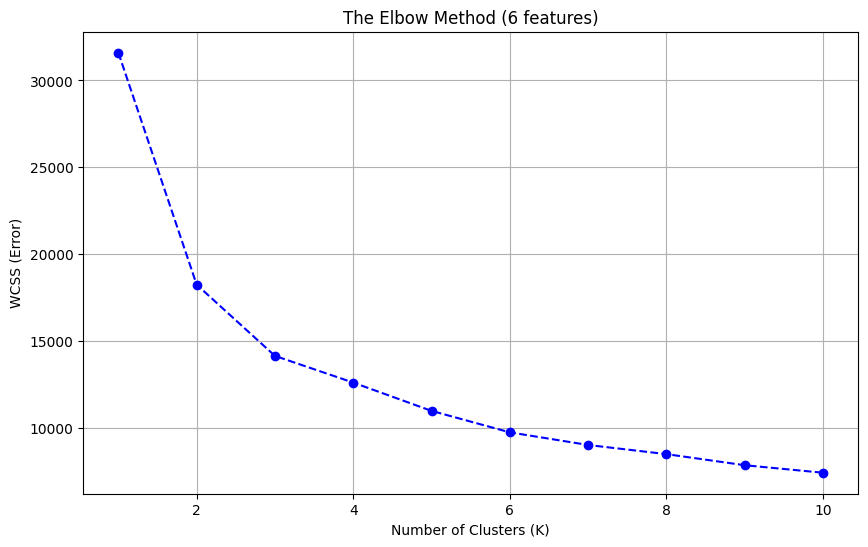

💡 Recommended: K=4 clusters


In [ ]:
# ============================================
# PREPROCESSING AND ELBOW METHOD 
# ============================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

print("Preparing features for clustering...")

# Use rfm_enhanced index (training customers only)
clustering_features = rfm_enhanced[[
    'Recency',
    'Frequency',
    'Monetary',
    'customer_age_days',
    'product_diversity',
    'avg_order_value'
]].copy()

# Reset index to avoid mismatch
clustering_features = clustering_features.reset_index(drop=True)
rfm_enhanced        = rfm_enhanced.reset_index(drop=True)

print(f"Clustering features shape: {clustering_features.shape}")

# Log transform
rfm_log = np.log(clustering_features + 1)

# Standardize
scaler         = StandardScaler()
rfm_normalized = scaler.fit_transform(rfm_log)

# Convert back to DataFrame
rfm_scaled = pd.DataFrame(
    rfm_normalized,
    index=clustering_features.index,
    columns=clustering_features.columns
)

print(f"rfm_scaled shape:          {rfm_scaled.shape}")
print(f"rfm_enhanced shape:        {rfm_enhanced.shape}")
print(f"Shapes match:              {len(rfm_scaled) == len(rfm_enhanced)}")

print("\nData Normalized!")
print(f"Features used: {list(rfm_scaled.columns)}")
print("\nSummary Stats (should be ~0 mean, ~1 std):")
print(rfm_scaled.describe().round(2))

# ELBOW METHOD
print("\n Running Elbow Method...")
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--', color='b')
plt.title(f'The Elbow Method ({len(clustering_features.columns)} features)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Error)')
plt.grid(True)
plt.show()

print("💡 Recommended: K=4 clusters")

Training Enhanced Churn Model...
Merged Data Shape: (5266, 20)

 Features:  17
Samples:   5266
Class Balance:
Retained (0): 2289 (43.5%)
Churned  (1): 2977 (56.5%)

 Split Complete:
Training: 4212 samples
Testing:  1054 samples

🔧 Training XGBoost Classifier...

MODEL PERFORMANCE REPORT
              precision    recall  f1-score   support

    Retained       0.73      0.63      0.68       458
     Churned       0.74      0.82      0.78       596

    accuracy                           0.74      1054
   macro avg       0.74      0.73      0.73      1054
weighted avg       0.74      0.74      0.74      1054

ROC-AUC Score: 0.796

 Confusion Matrix:
True Negatives  (Correct Retained): 289
False Positives (False Alarm):       169
False Negatives (Missed Churners):   105
True Positives  (Caught Churners):   491

 Generating Feature Importance Plot...


<Figure size 1200x800 with 0 Axes>

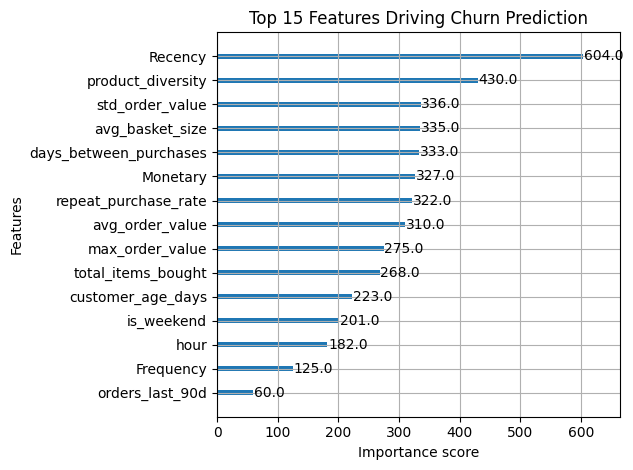


 Model Training Complete!
Features used: 17 (vs original 3 RFM)
No data leakage - features built from past data only!


In [22]:
# ============================================
# STEP 3: TRAINING THE PREDICTION MODEL (Enhanced)
# ============================================
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np

print("Training Enhanced Churn Model...")
print("="*60)

# --- 1. MERGE FEATURES WITH LABELS ---
# targets already created in Cell 3 (no leakage!)
model_data = rfm_enhanced.merge(targets, on='Customer ID', how='inner')
print(f"Merged Data Shape: {model_data.shape}")

# --- 2. SELECT FEATURES ---
feature_columns = [
    'Recency', 'Frequency', 'Monetary',
    'customer_age_days', 'days_between_purchases',
    'orders_last_30d', 'orders_last_90d',
    'avg_order_value', 'max_order_value', 'std_order_value',
    'product_diversity', 'repeat_purchase_rate',
    'avg_basket_size', 'total_items_bought',
    'is_weekend', 'hour', 'spending_increasing'
]

X = model_data[feature_columns].fillna(0)
y = model_data['Churn']

print(f"\n Features:  {len(feature_columns)}")
print(f"Samples:   {len(X)}")
print(f"Class Balance:")
print(f"Retained (0): {(y==0).sum()} ({(y==0).mean():.1%})")
print(f"Churned  (1): {(y==1).sum()} ({(y==1).mean():.1%})")

# --- 3. TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\n Split Complete:")
print(f"Training: {len(X_train)} samples")
print(f"Testing:  {len(X_test)} samples")

# --- 4. TRAIN MODEL ---
print("\n🔧 Training XGBoost Classifier...")
model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    random_state=42,
    eval_metric='logloss'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# --- 5. EVALUATE ---
y_pred       = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\n" + "="*60)
print("MODEL PERFORMANCE REPORT")
print("="*60)
print(classification_report(y_test, y_pred, target_names=['Retained', 'Churned']))

roc_score = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_score:.3f}")

# Confusion Matrix
print("\n Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(f"True Negatives  (Correct Retained): {cm[0][0]}")
print(f"False Positives (False Alarm):       {cm[0][1]}")
print(f"False Negatives (Missed Churners):   {cm[1][0]}")
print(f"True Positives  (Caught Churners):   {cm[1][1]}")

# --- 6. FEATURE IMPORTANCE ---
print("\n Generating Feature Importance Plot...")
plt.figure(figsize=(12, 8))
plot_importance(
    model,
    importance_type='weight',
    max_num_features=15,
    title='Top 15 Features Driving Churn Prediction',
    show_values=True
)
plt.tight_layout()
plt.show()

print(f"\n Model Training Complete!")
print(f"Features used: {len(feature_columns)} (vs original 3 RFM)")
print(f"No data leakage - features built from past data only!")

1/4: Creating SHAP explainer...
SHAP values calculated!

2/4: Generating summary plot...


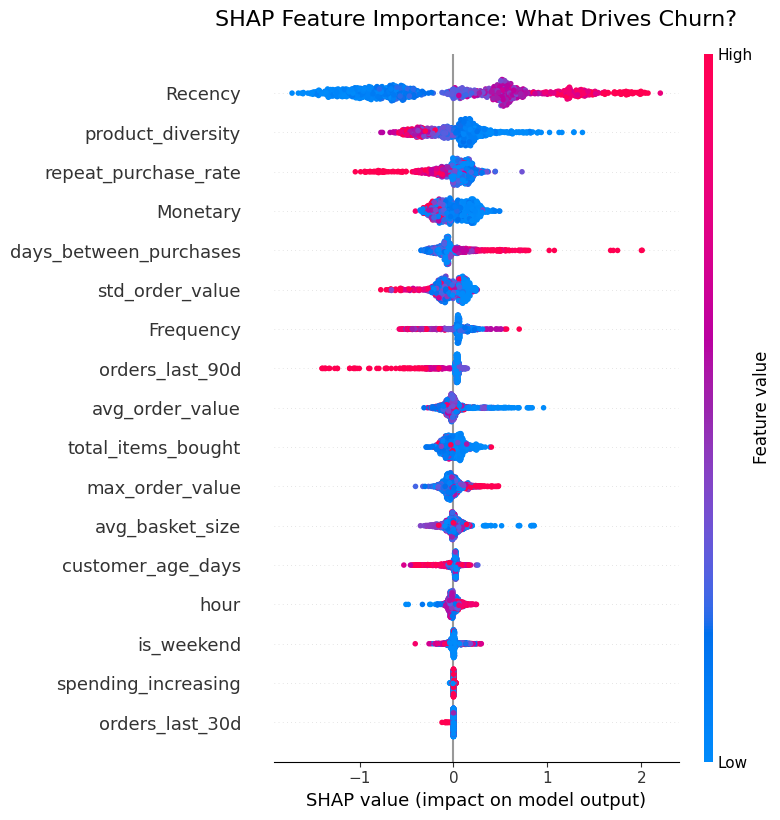

Saved: shap_summary.png

3/4: Creating explanation function...

4/4: Testing on real customers...

EXAMPLE 1: HIGH-RISK CUSTOMER WHO ACTUALLY CHURNED
 CHURN EXPLANATION - Customer Index 2

 Churn Probability : 77.7%
 Risk Level        : HIGH
 Actual Outcome    : Churned

 Top 5 Contributing Factors:

  1. Recency: 404.00
     INCREASES churn risk by 1.0101

  2. Monetary: 549.05
     DECREASES churn risk by 0.2034

  3. product_diversity: 30.00
     INCREASES churn risk by 0.1737

  4. max_order_value: 549.05
     DECREASES churn risk by 0.1394

  5. std_order_value: 0.00
     INCREASES churn risk by 0.1240


EXAMPLE 2: LOW-RISK CUSTOMER WHO WAS RETAINED
 CHURN EXPLANATION - Customer Index 0

 Churn Probability : 76.9%
 Risk Level        : HIGH
 Actual Outcome    : Retained

 Top 5 Contributing Factors:

  1. Recency: 244.00
     INCREASES churn risk by 0.7657

  2. std_order_value: 66.84
     DECREASES churn risk by 0.2180

  3. Monetary: 289.52
     INCREASES churn risk by 0.2078

  

In [23]:
# ============================================
# STEP 4: SHAP EXPLANATIONS (Explainable AI)
# ============================================
import shap
import joblib
import os

# --- 1. CREATE SHAP EXPLAINER ---
print("1/4: Creating SHAP explainer...")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
print("SHAP values calculated!")

# --- 2. SUMMARY PLOT ---
print("\n2/4: Generating summary plot...")
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, show=False)
plt.title("SHAP Feature Importance: What Drives Churn?", fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('../models/shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: shap_summary.png")

# --- 3. INDIVIDUAL EXPLANATION FUNCTION ---
print("\n3/4: Creating explanation function...")

def explain_customer_prediction(customer_index):
    customer_features = X_test.iloc[customer_index]
    customer_shap    = shap_values[customer_index]
    prediction       = model.predict_proba(customer_features.values.reshape(1, -1))[0][1]
    actual_label     = y_test.iloc[customer_index]

    feature_impacts = pd.DataFrame({
        'Feature':     X_test.columns,
        'Value':       customer_features.values,
        'SHAP_Impact': customer_shap
    }).sort_values('SHAP_Impact', key=abs, ascending=False)

    print("=" * 70)
    print(f" CHURN EXPLANATION - Customer Index {customer_index}")
    print("=" * 70)
    print(f"\n Churn Probability : {prediction:.1%}")
    print(f" Risk Level        : {'HIGH' if prediction > 0.7 else 'MEDIUM' if prediction > 0.4 else 'LOW'}")
    print(f" Actual Outcome    : {'Churned' if actual_label == 1 else 'Retained'}")
    print(f"\n Top 5 Contributing Factors:\n")

    for i, (_, row) in enumerate(feature_impacts.head(5).iterrows(), 1):
        direction = "INCREASES" if row['SHAP_Impact'] > 0 else "DECREASES"
        print(f"  {i}. {row['Feature']}: {row['Value']:.2f}")
        print(f"     {direction} churn risk by {abs(row['SHAP_Impact']):.4f}\n")

    return feature_impacts

# --- 4. TEST ON REAL CUSTOMERS ---
print("\n4/4: Testing on real customers...\n")

high_risk_customers = X_test[y_test == 1].index
if len(high_risk_customers) > 0:
    print("EXAMPLE 1: HIGH-RISK CUSTOMER WHO ACTUALLY CHURNED")
    explain_customer_prediction(X_test.index.get_loc(high_risk_customers[0]))

low_risk_customers = X_test[y_test == 0].index
if len(low_risk_customers) > 0:
    print("\nEXAMPLE 2: LOW-RISK CUSTOMER WHO WAS RETAINED")
    explain_customer_prediction(X_test.index.get_loc(low_risk_customers[0]))

# --- 5. SAVE EXPLAINER ---
explainer_path = '../models/shap_explainer.pkl'
joblib.dump(explainer, explainer_path)
print(f"\n SHAP explainer saved to {explainer_path}")

print("\n SHAP ANALYSIS COMPLETE!")

Running KMeans Clustering...
Clusters assigned!
Cluster
0     990
1    1630
2    1437
3    1209
Name: count, dtype: int64

Customer Segments Profile:


,Recency,Frequency,Monetary,Count
Cluster,,,,
0,33.42,17.98,9938.96,990
1,330.82,1.07,297.14,1630
2,193.98,4.62,2114.49,1437
3,197.89,3.22,576.99,1209


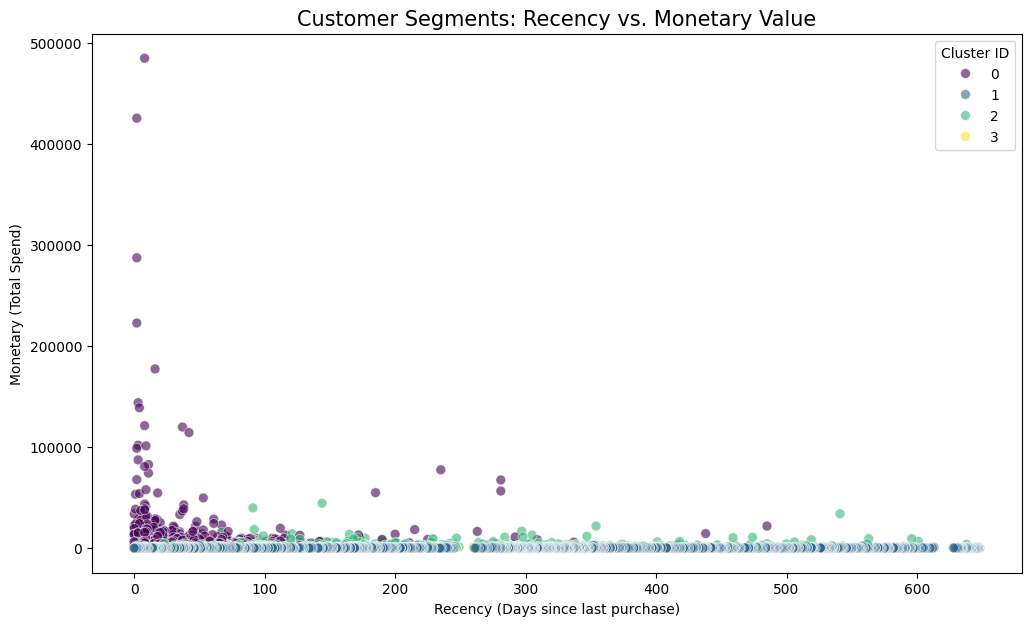


Cluster distribution:
Cluster
Slipping Away (Loyal)    1630
The Best (Champions)     1437
The Potentials (New)     1209
At-Risk (Low-Value)       990
Name: count, dtype: int64


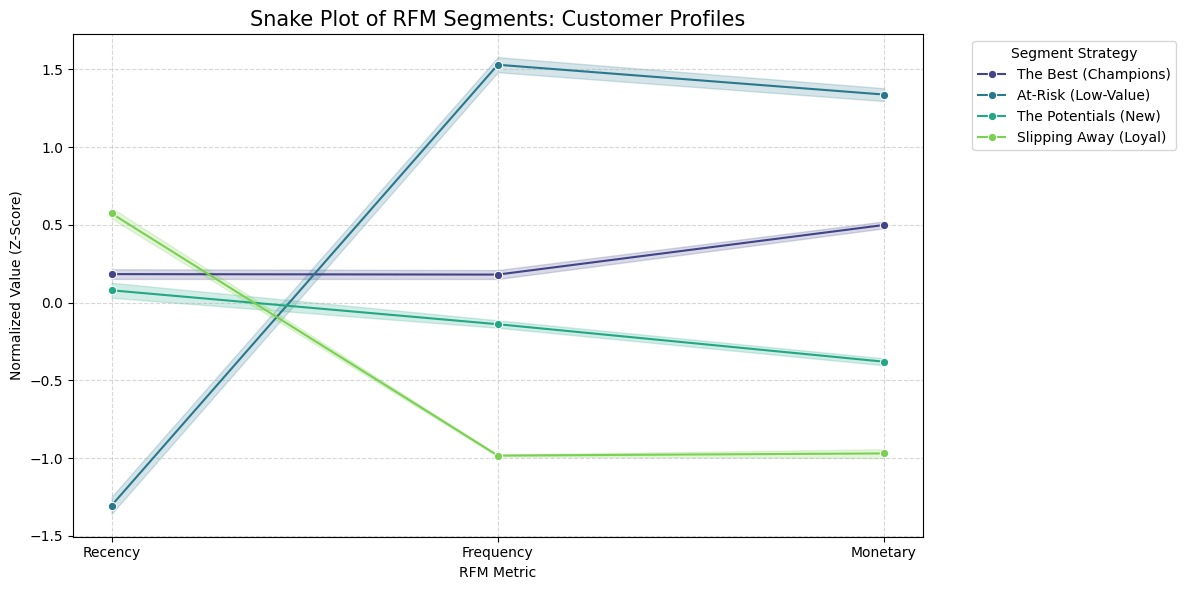


Clustering & Snake Plot Complete!


In [25]:
# ============================================
# KMEANS CLUSTERING + SNAKE PLOT
# ============================================
import seaborn as sns
from sklearn.cluster import KMeans

# --- PART 1: RUN KMEANS ---
print("Running KMeans Clustering...")

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Add clusters to  dataframes
rfm_enhanced['Cluster'] = cluster_labels
rfm_enhanced['Cluster'] = rfm_enhanced['Cluster'].astype(int)

print("Clusters assigned!")
print(rfm_enhanced['Cluster'].value_counts().sort_index())

# --- PART 2: INTERPRETATION TABLE ---
cluster_summary = rfm_enhanced.groupby('Cluster').agg({
    'Recency':   'mean',
    'Frequency': 'mean',
    'Monetary':  'mean',
    'Cluster':   'count'
}).rename(columns={'Cluster': 'Count'})

print("\nCustomer Segments Profile:")
display(cluster_summary.round(2))

# --- PART 3: SCATTER PLOT ---
plt.figure(figsize=(12, 7))
sns.scatterplot(
    data=rfm_enhanced,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='viridis',
    s=50,
    alpha=0.6
)
plt.title('Customer Segments: Recency vs. Monetary Value', fontsize=15)
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary (Total Spend)')
plt.legend(title='Cluster ID')
plt.show()

# --- PART 4: SNAKE PLOT ---
# Cluster name mapping
cluster_map = {
    2: 'The Best (Champions)',
    3: 'The Potentials (New)',
    1: 'Slipping Away (Loyal)',
    0: 'At-Risk (Low-Value)'
}

# Build normalized dataframe for snake plot
df_normalized = pd.DataFrame(
    rfm_scaled[['Recency', 'Frequency', 'Monetary']].values,
    columns=['Recency', 'Frequency', 'Monetary']
)
df_normalized['Cluster'] = rfm_enhanced['Cluster'].map(cluster_map).values
df_normalized['Cluster'] = df_normalized['Cluster'].fillna('Other')

print("\nCluster distribution:")
print(df_normalized['Cluster'].value_counts())

# Melt for plotting
df_melt = pd.melt(
    df_normalized.reset_index(),
    id_vars=['Cluster'],
    value_vars=['Recency', 'Frequency', 'Monetary'],
    var_name='Metric',
    value_name='Value'
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(
    x='Metric',
    y='Value',
    hue='Cluster',
    data=df_melt,
    palette='viridis',
    marker='o'
)
plt.title('Snake Plot of RFM Segments: Customer Profiles', fontsize=15)
plt.xlabel('RFM Metric')
plt.ylabel('Normalized Value (Z-Score)')
plt.legend(title='Segment Strategy', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nClustering & Snake Plot Complete!")

In [28]:
# ============================================
# STEP 5: SAVE ENHANCED MODEL + METADATA
# ============================================
import joblib
import json
import os
from datetime import datetime

print(" Saving model and metadata...")

# Determine correct path
if os.path.exists('../models'):
    model_dir = '../models'
else:
    model_dir = 'models'
    os.makedirs(model_dir, exist_ok=True)

# --- 1. SAVE MODEL ---
model_path = os.path.join(model_dir, 'xgboost_churn.pkl')
joblib.dump(model, model_path)
print(f"Model saved: {model_path}")

# --- 2. SAVE FEATURE NAMES (Critical for API) ---
feature_metadata = {
    'feature_names': feature_columns,
    'feature_count': len(feature_columns),
    'model_type': 'XGBoost',
    'n_estimators': 200,
    'max_depth': 5,
    'trained_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    
    # Performance metrics
    'accuracy': float(model.score(X_test, y_test)),
    'roc_auc': float(roc_score),
    'train_samples': len(X_train),
    'test_samples': len(X_test),
    'churn_rate': float(y.mean()),
    
    # Feature list for reference
    'features_used': {
        'rfm_basic': ['Recency', 'Frequency', 'Monetary'],
        'temporal': ['customer_age_days', 'days_between_purchases', 'orders_last_30d', 'orders_last_90d'],
        'transaction': ['avg_order_value', 'max_order_value', 'std_order_value'],
        'behavioral': ['product_diversity', 'repeat_purchase_rate', 'avg_basket_size', 'total_items_bought'],
        'patterns': ['is_weekend', 'hour', 'spending_increasing']
    }
}

metadata_path = os.path.join(model_dir, 'model_metadata.json')
with open(metadata_path, 'w') as f:
    json.dump(feature_metadata, f, indent=2)
print(f"Metadata saved: {metadata_path}")

# --- 3. SAVE CUSTOMER DATABASE (for API) ---
customer_db_path = os.path.join(model_dir, 'customer_database.csv')
rfm_enhanced.to_csv(customer_db_path, index=False)
print(f"Customer database saved: {customer_db_path}")
print(f"Total customers: {len(rfm_enhanced)}")
print("\nModel and metadata saving complete!")

 Saving model and metadata...
Model saved: ../models\xgboost_churn.pkl
Metadata saved: ../models\model_metadata.json
Customer database saved: ../models\customer_database.csv
Total customers: 5266

Model and metadata saving complete!


In [ ]:
import os

# Show exact project structure
project_root = os.path.abspath('../')
print(f"📁 Project Root: {project_root}")
print()

for root, dirs, files in os.walk(project_root):
    # Skip hidden folders and pycache
    dirs[:] = [d for d in dirs if not d.startswith('.')
               and d != '__pycache__'
               and d != '.git']
    
    level  = root.replace(project_root, '').count(os.sep)
    indent = '   ' * level
    print(f'{indent}📁 {os.path.basename(root)}/')
    
    subindent = '   ' * (level + 1)
    for file in files:
        print(f'{subindent}📄 {file}')
        